# Task 3 Treatment Exercise - Ander Carrera

You work for a startup that sells machine learning based solutions to public institutions
and private companies. A well-known hospital has hired your startup to **build a machine
learning model that tells which treatment or “drug” should a new incoming patient
receive.**

In order to create that model, the hospital has provided you a dataset with already
treated patients. The dataset is called “Treatment.csv” and stores some useful
information of each patient, as well as the treatment (drug) each patient has received.

Your job is to create a machine learning model that best classifies a new incoming
patient.

Hints:
- The hospital will make the payment as soon as you upload a “good enough”
jupyter notebook to Mudle.

- “Good enough” means:
    - Explain with comments very briefly what are you doing in every step of
the notebook and why (if it is necessary). Remember that the hospital
personnel are not ML experts and they have to understand your work.
    - Include in the notebook all the algorithms you tried, don’t leave only the
best. In this way they can see all the work you’ve done.
    - Clearly explain the results you achieved.

## EDA

Now we are going to analyze each variable and show 5 examples of each:

Sex: gender of the patient. Binary (F or M):

#,Sex
1,F
2,M
3,M
4,F
5,F

BP (Blood pressure): Type of blood pressure of the patient, categorical (HIGH, NORMAL, LOW) We could transform it into numerical using one-hot-encoding.

#,BP
1,HIGH
2,LOW
3,LOW
4,NORMAL
5,LOW

Cholesterol: Type of cholesterol of the patient, binary (HIGH, NORMAL) we could transform it into numerical using one-hot-encoding.

#,Cholesterol
9,HIGH
10,NORMAL
11,HIGH
12,NORMAL
13,HIGH

Na_to_K: Sodium-potassium (Na:K) ratio, Numeric continue value

#,Na_to_K
1,25.355
2,13.093
3,10.114
4,7.798
5,18.043

### This is the output (model) we want to predict

Drug: The type of drug that has to be given to a patient, categorical. 5 types fixed. (A B C Y X).

#,Drug
45,drugX
46,drugX
47,drugA
48,drugC
49,DrugY

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Comment this if the data visualisations doesn't work on your side

plt.style.use('bmh')

In [2]:
df = pd.read_csv('../data/Treatment.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [3]:
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


**The first question we must answer is: what type of variable is the output variable? By answering this question we will know the type of problem we have. In this case, since `Drug` is a categorical variable, we are dealing with a classification problem**.

In [4]:
for col in df.columns:
    print("{} : {}".format(col, df[col].isnull().sum()))

Age : 0
Sex : 0
BP : 0
Cholesterol : 0
Na_to_K : 0
Drug : 0


With above information we can already deduce that all the variables are relevant, since there are no missing values.


## Pre processing


Let's see what types of data we have in the dataset, and we will plot those which are numeric and categorical


In [5]:
list(set(df.dtypes.tolist()))


[dtype('float64'), dtype('int64'), dtype('O')]

In [6]:
df_num = df.select_dtypes(include=['float64', 'int64'])
df_num.head()

,Age,Na_to_K
0,23,25.355
1,47,13.093
2,47,10.114
3,28,7.798
4,61,18.043


In [7]:
df_num = df.select_dtypes(include=['O'])
df_num.head()

,Sex,BP,Cholesterol,Drug
0,F,HIGH,HIGH,DrugY
1,M,LOW,HIGH,drugC
2,M,LOW,HIGH,drugC
3,F,NORMAL,HIGH,drugX
4,F,LOW,HIGH,DrugY


We've just seen above that we only have 2 numeric variables, which is too little to get a 'good enough' model. For this, we will transform the categorical variables into numerical variables.

So we will transform `Sex` `BP` `Drug` and `Cholesterol`, and we will use the `One-hot-encoding` method, as we have a fixed possible variables per column (Sex has F&M, BP has High Low Normal, CHolesterol has High Normal and Drug has Drug A B C Y X) and we don't want to give a certain order logic to those variables.

In [8]:
encoded_data = pd.get_dummies(df, columns =['Sex', 'BP', 'Cholesterol', 'Drug'])

Above we have an example of the complete encoded data, but the data we are going to use for training will be an encoded data regarding input variables:

In [9]:
feature = pd.get_dummies(df, columns =['Sex', 'BP', 'Cholesterol']).drop('Drug', axis=1)

feature.sample(10)

,Age,Na_to_K,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
50,58,19.416,1,0,1,0,0,1,0
137,35,12.894,1,0,1,0,0,1,0
96,58,38.247,1,0,0,1,0,1,0
165,38,18.295,0,1,0,1,0,1,0
151,68,11.009,0,1,1,0,0,1,0
60,38,29.875,1,0,0,1,0,0,1
193,72,6.769,0,1,0,1,0,1,0
146,37,12.006,1,0,0,1,0,0,1
124,53,12.495,1,0,1,0,0,0,1
145,61,9.443,0,1,0,0,1,1,0


Once we have preprocessed our data, we are going to focus on the class balancing of our output variable `Drug`:

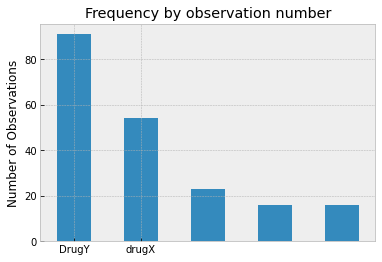

In [10]:
count_classes = pd.value_counts(df['Drug'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2))
plt.title("Frequency by observation number")
plt.ylabel("Number of Observations");

Above we can see that `Drug` is not balanced at all.

We will apply the following strategy to try to improve the situation.

**Balanced Ensemble Methods:** Uses the advantages of ensemble methods, i.e., training different models and among all of them obtaining the final result (for example "voting") but makes sure to take balanced training samples.
Let's apply this technique one by one to our code and see the results.


## Training

Once we have pre processed our data, now we can focus on training our model.

Before diving deep into modelling and making predictions, we need to split our data set into a training set and test set. That way, we can train an algorithm on the training set, and make predictions on the test set. The error metrics will be much more relevant this way, since the algorithm will make predictions on data it has not seen before.


In [11]:
from sklearn.model_selection import train_test_split

target = np.ravel(df['Drug'])

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42)

# Show the Training and Testing Data
print('Shape of training feature:', X_train.shape)
print('Shape of testing feature:', X_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)

Shape of training feature: (160, 9)
Shape of testing feature: (40, 9)
Shape of training label: (160,)
Shape of training label: (40,)


Finally, we use the train_test_split function. The test_size parameter corresponds to the fraction of the data set that will be used for testing. Usually, we use 20%. Then, the random_state parameter is used for reproducibility. It can be set to any number, but it will ensure that every time the code runs, the data set will be split identically. If no random_state is provided, then the train and test set will differ, since the function splits it randomly.

BUT... before we start, let's run the "unbalanced" Logistic Regression model, to have a "baseline", i.e. some metrics against which we can compare and see if we improve.


### Linear Regression (Unbalanced baseline)

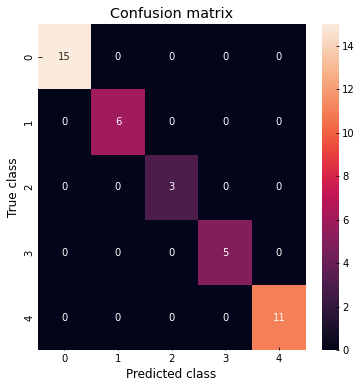

Accuracy: 100.0%
              precision    recall  f1-score   support

       DrugY       1.00      1.00      1.00        15
       drugA       1.00      1.00      1.00         6
       drugB       1.00      1.00      1.00         3
       drugC       1.00      1.00      1.00         5
       drugX       1.00      1.00      1.00        11

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

#creamos una función que crea el modelo que usaremos cada vez
def run_linear_reg_unbalanced_model(X_train, X_test, y_train, y_test, random_state):
    clf_base = LogisticRegression(random_state=random_state, solver="newton-cg")
    clf_base.fit(X_train, y_train)
    return clf_base

#ejecutamos el modelo "tal cual"
model = run_linear_reg_unbalanced_model(X_train, X_test, y_train, y_test, 42)

#definimos funciona para mostrar los resultados
def show_results(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print ('Accuracy: {}%'.format(accuracy_score(y_test, y_pred)*100))
    print (classification_report(y_test, y_pred))

y_pred = model.predict(X_test)
show_results(y_test, y_pred)

### Linear Regression (Balanced)

Let's do the same but doing some class balancing via `class_weight`. THis hyper parameter will give more weight to the fewer repeated variables and vice-bersa.


In [13]:
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(random_state=42, solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf

model = run_model_balanced(X_train, X_test, y_train, y_test)
y_pred = model.predict(X_test)


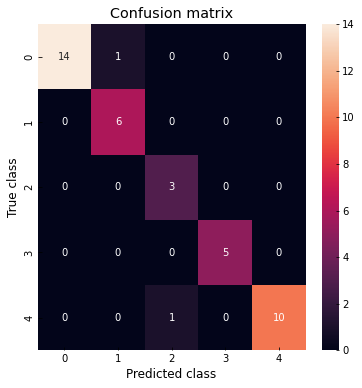

Accuracy: 95.0%
              precision    recall  f1-score   support

       DrugY       1.00      0.93      0.97        15
       drugA       0.86      1.00      0.92         6
       drugB       0.75      1.00      0.86         3
       drugC       1.00      1.00      1.00         5
       drugX       1.00      0.91      0.95        11

    accuracy                           0.95        40
   macro avg       0.92      0.97      0.94        40
weighted avg       0.96      0.95      0.95        40



In [14]:
show_results(y_test, y_pred)

We have seen that results are worse than the initial baseline. Why?

Maybe it's because of the lack of data. Given that we have a dataset with very little data, and even if we have the output variable unbalanced, I think that even if we think that we have to balance the class, when we have little data it is not necessary to balance the class, since we can obtain worse results as we have seen in the previous section.

Or also it's maybe because we had a lot of luck with the `random_state` seed declared in the baseline model. The `random_state` is a seed that you declare to randomly pick certain values. With the same seed it will logically pick the same random values all the time. To vary this, we can repeat the process with different seeds

### Linear Regression (Unbalanced baseline (Seed 1))


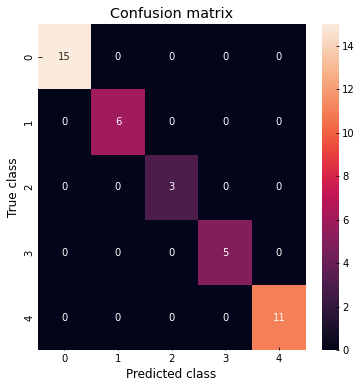

Accuracy: 100.0%
              precision    recall  f1-score   support

       DrugY       1.00      1.00      1.00        15
       drugA       1.00      1.00      1.00         6
       drugB       1.00      1.00      1.00         3
       drugC       1.00      1.00      1.00         5
       drugX       1.00      1.00      1.00        11

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [15]:
model = run_linear_reg_unbalanced_model(X_train, X_test, y_train, y_test, 1)
y_pred = model.predict(X_test)
show_results(y_test, y_pred)

### Linear Regression (Unbalanced baseline (Seed 2))


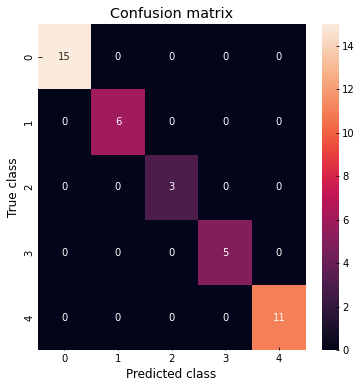

Accuracy: 100.0%
              precision    recall  f1-score   support

       DrugY       1.00      1.00      1.00        15
       drugA       1.00      1.00      1.00         6
       drugB       1.00      1.00      1.00         3
       drugC       1.00      1.00      1.00         5
       drugX       1.00      1.00      1.00        11

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [16]:
model = run_linear_reg_unbalanced_model(X_train, X_test, y_train, y_test, 2)
y_pred = model.predict(X_test)
show_results(y_test, y_pred)

### Linear Regression (Unbalanced baseline (Seed 3))


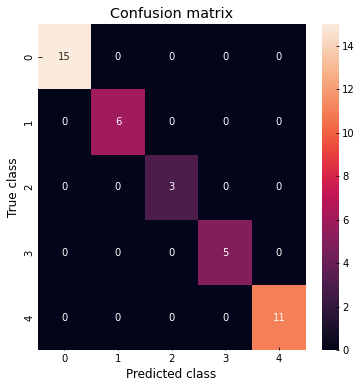

Accuracy: 100.0%
              precision    recall  f1-score   support

       DrugY       1.00      1.00      1.00        15
       drugA       1.00      1.00      1.00         6
       drugB       1.00      1.00      1.00         3
       drugC       1.00      1.00      1.00         5
       drugX       1.00      1.00      1.00        11

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [17]:
model = run_linear_reg_unbalanced_model(X_train, X_test, y_train, y_test, 3)
y_pred = model.predict(X_test)
show_results(y_test, y_pred)

We have seen in these 3 unbalanced linear regression models that accuracy remains great, so we can discard that the culprit is the seed selection, so for linear regression, we stick to the theory n.1 that we have talked about earlier this part

Another cause of this could be that this algorythm is not great to treat balanced data. Let's see how performs the model with other algorithms:

### Decision Tree

The importance of the features are: [2.50000000e-01 2.50000000e-01 0.00000000e+00 2.22044605e-16
 2.50000000e-01 1.34336986e-14 1.40909091e-01 1.09090909e-01
 0.00000000e+00]


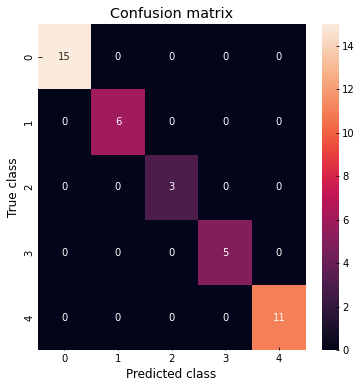

Accuracy: 100.0%
              precision    recall  f1-score   support

       DrugY       1.00      1.00      1.00        15
       drugA       1.00      1.00      1.00         6
       drugB       1.00      1.00      1.00         3
       drugC       1.00      1.00      1.00         5
       drugX       1.00      1.00      1.00        11

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [18]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(random_state=42, class_weight="balanced")
classifier.fit(X_train, y_train)

print('The importance of the features are: {}'.format(classifier.feature_importances_))

y_pred = classifier.predict(X_test)

show_results(y_test, y_pred)

With these results, we can think at first that our model is perfect. But this can not be very representative, because one downside is building a single tree is its instability, which can be improved through ensemble techniques such as random forests, boosting, etc. For now, let’s move on to the next model.

### Random Forest


The importance of the features are: [0.20536633 0.32264739 0.00875078 0.00682102 0.17307483 0.10507868
 0.09316227 0.04558508 0.03951363]


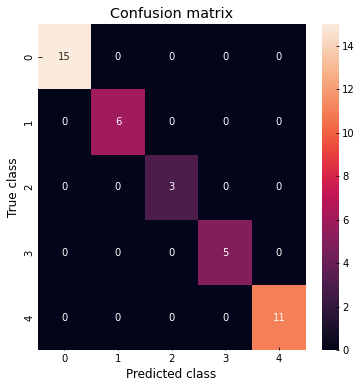

Accuracy: 100.0%
              precision    recall  f1-score   support

       DrugY       1.00      1.00      1.00        15
       drugA       1.00      1.00      1.00         6
       drugB       1.00      1.00      1.00         3
       drugC       1.00      1.00      1.00         5
       drugX       1.00      1.00      1.00        11

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [19]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state=42, class_weight="balanced")
classifier.fit(X_train, y_train)

print('The importance of the features are: {}'.format(classifier.feature_importances_))

y_pred = classifier.predict(X_test)

show_results(y_test, y_pred)

We have seen that with the random forest it has also worked perfectly. Although at the beginning we thought that the decision tree might not be representative due to the lack of variability in the samples, with this algorithm we have shown that it was indeed representative.

# Final thoughts

We have observed that with the linear regression algorithm with the unbalanced class, better results have been obtained than with the balanced class. It has been shown that this was not because of the `random_state` seed, but that indeed this algorithm does not work well when we have little data and these are balanced. In short, for linear regression when there is little data it is better not to balance it on purpose.

As far as tree algorithms such as Decision tree and random forest are concerned, it has been shown that they have worked well with balanced classes, unlike linear regression, and that the results obtained have been perfect.